In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [2]:
ra = "glos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,Station ID,Dataset (ERDDAP) ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)","RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,45013,obs_2,45013,"Station 45013 - Atwater Park, WI",Milwaukee Buoy ATW20 (45013),43.1,-87.85,moored_buoy,2011-08-12 00:00:00,Y,Yf,University of Wisconsin-Milwaukee,academic,"wind_from_direction, wind_speed, wind_speed_o...",NaN
1,45014,obs_43,45014,"Station 45014 - GB17 - South Green Bay, WI",Green Bay Buoy GB17 (45014),44.8,-87.76,moored_buoy,2011-08-12 00:00:00,Y,Yf,University of Wisconsin-Milwaukee,academic,"wind_from_direction, wind_speed, wind_speed_of...",NaN
2,45022,obs_61,45022,"Station 45022 - Little Traverse Bay, MI",Little Traverse Bay Buoy U-GLOS 004 (45022),45.403,-85.088,moored_buoy,2009-07-29 00:00:00,Y,Yf,University of Michigan CIGLR,academic,"wind_from_direction, wind_speed, wind_speed_of...",NaN
3,45023,obs_44,45023,"Station 45023 - North Entry Buoy, North Keween...",North Entry MTU Buoy (45023),47.27,-88.607,moored_buoy,2010-07-08 00:00:00,Y,Yf,Michigan Tech University,academic,"wind_from_direction, wind_speed, wind_speed_o...",NaN
4,45024,obs_62,45024,"Station 45024 - Ludington Buoy, MI",Ludington Buoy (45024),43.977,-86.559,moored_buoy,2009-08-04 00:00:00,Y,Yf,University of Michigan CIGLR,academic,NaN,NaN


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [3]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

Columns missing: {'Platform Maintainer', 'Platform Funder/Sponsor', 'Data Manager', 'RA'}
Columns added: {'Dataset (ERDDAP) ID'}


Make a plot of all points.

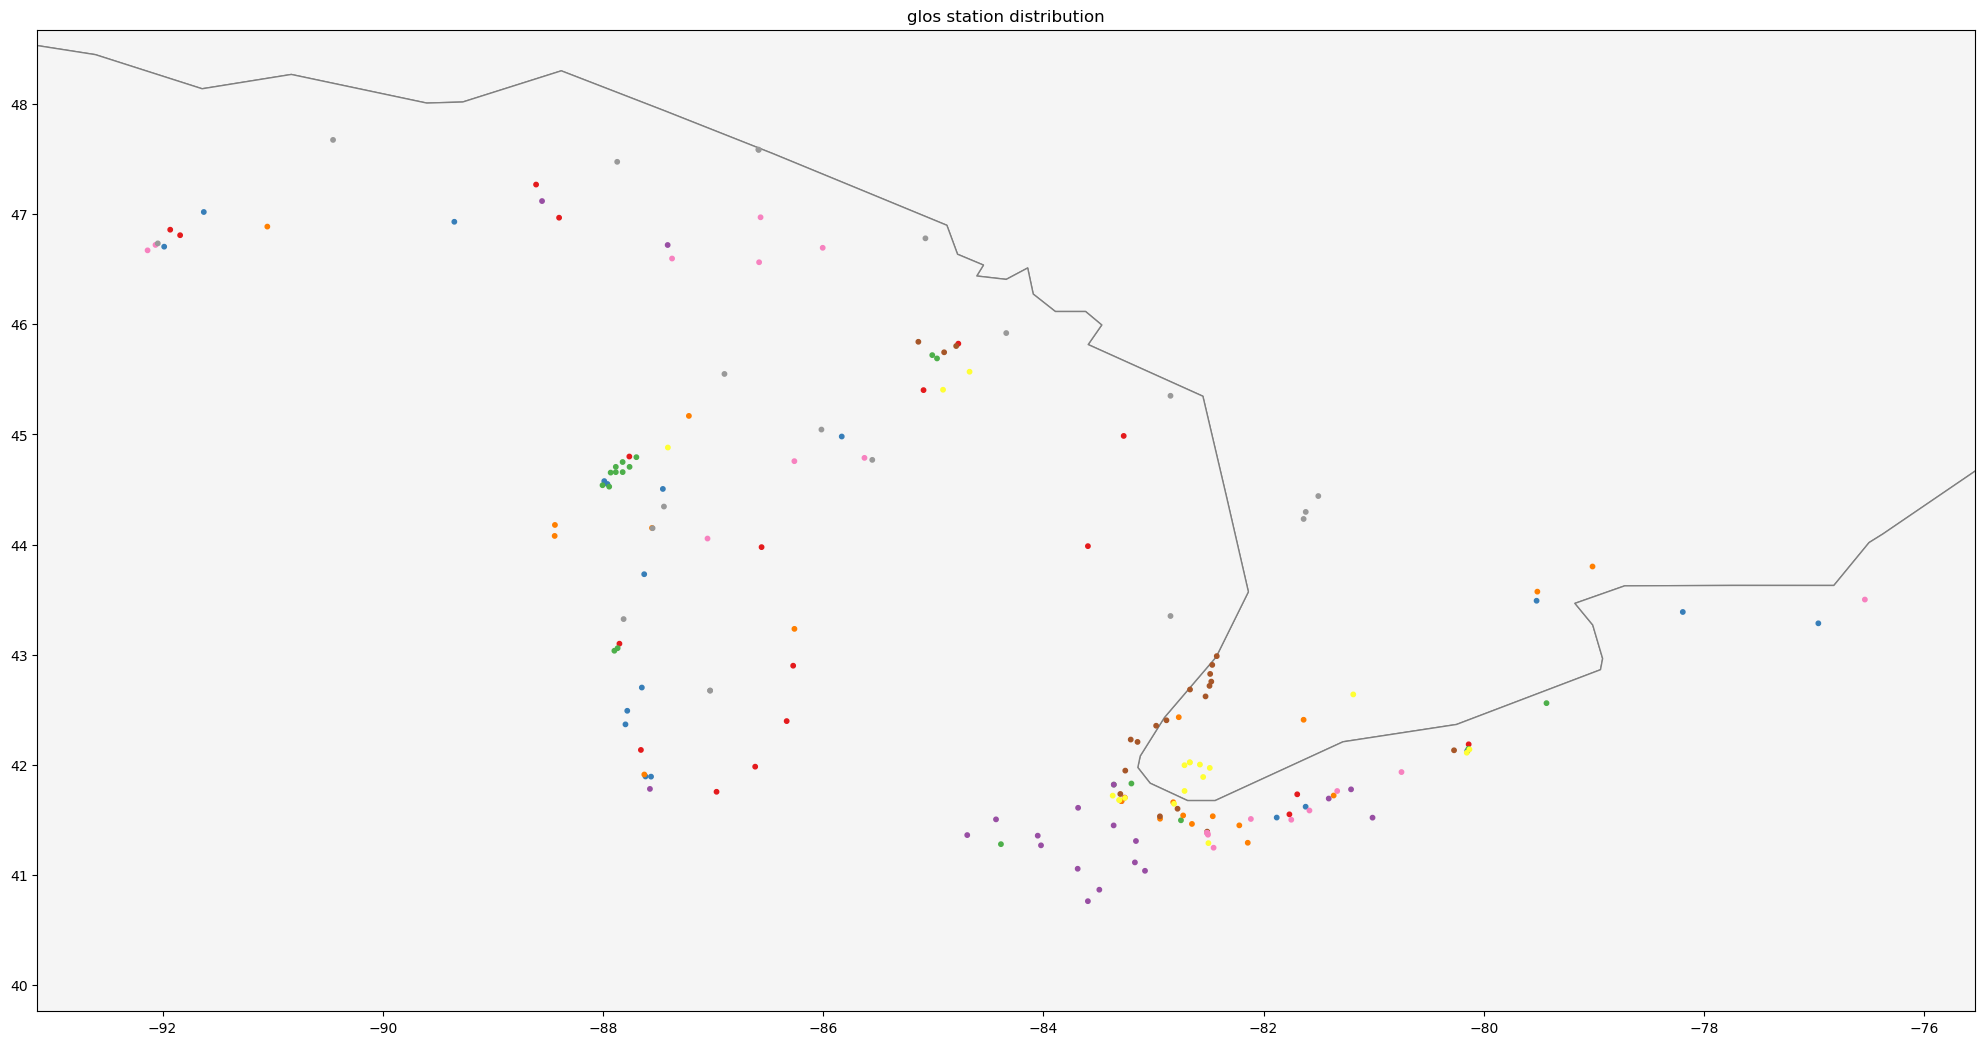

In [4]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [5]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [6]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://seagull-erddap.glos.org/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [7]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [8]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [ ]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
#search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist(),
                          'Station ID': resp['Station ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist(),
                              'Station ID': resp['Station ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist(),
                                  'Station ID': resp['Station ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Dataset (ERDDAP) ID" = "obs_2"
Found "obs_2": ['obs_206', 'obs_216', 'obs_209', 'obs_210', 'obs_213', 'obs_253', 'obs_249', 'obs_23', 'obs_231', 'obs_232', 'obs_230', 'obs_289', 'obs_277', 'obs_280', 'obs_268', 'obs_282', 'obs_283', 'obs_287', 'obs_293', 'obs_217', 'obs_269', 'obs_271', 'obs_272', 'obs_270', 'obs_273', 'obs_274', 'obs_298', 'obs_227', 'obs_211', 'obs_251', 'obs_221', 'obs_224', 'obs_219', 'obs_281', 'obs_261', 'obs_24', 'obs_248', 'obs_21', 'obs_275', 'obs_215', 'obs_288', 'obs_285', 'obs_284', 'obs_207', 'obs_208', 'obs_212', 'obs_266', 'obs_255', 'obs_297', 'obs_294', 'obs_205', 'obs_229', 'obs_222', 'obs_22', 'obs_250', 'obs_279', 'obs_226', 'obs_220', 'obs_214', 'obs_263', 'obs_262', 'obs_260', 'obs_259', 'obs_258', 'obs_257', 'obs_256', 'obs_201', 'obs_203', 'obs_204', 'obs_278', 'obs_286', 'obs_267', 'obs_265', 'obs_276', 'obs_264', 'obs_296', 'obs_246', 'obs_254', 'obs_20', 'obs_223', 'obs_225', 'obs_299', 'obs_228', 'obs_202', 'obs_218', 'obs_241', '

Print the stations that we couldn't find.

In [10]:
len(not_found)

115

In [11]:
len(found)

62

Show me the record that has NaN for the first search element.

In [12]:
df.loc[df[search_order[0]].isna()]

,Station ID,Dataset (ERDDAP) ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)","RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Variable Names,Additional notes,geometry
20,45177,NaN,45177,Ohio St. Beach Buoy,NaN,41.894,-87.613,moored_buoy,>5 year,Y,N,Chicago Parks District,gov_municipal,"sea_water_turbidity, sea_surface_temperature, ...",NaN,POINT (-87.61300 41.89400)
32,45199,NaN,45199,Salmon Unlimited WI buoy,NaN,42.7017,-87.6466,moored_buoy,2022,Y,N,Salmon Unlimited WI,nonprofit,"air_pressure_at_mean_sea_level, air_temperatur...",There are time lag issues with data reporting ...,POINT (-87.64660 42.70170)
33,45216,NaN,45216,"Ontonogan, MI Buoy",NaN,46.932,-89.349548,moored_buoy,nan,Y,Yf,Michigan Tech University,academic,"wind_from_direction, wind_speed, air_temperatu...",NaN,POINT (-89.34955 46.93200)
34,45217,NaN,45217,Wisconsin Point Buoy,NaN,46.705858,-91.984722,moored_buoy,2024-06-01 00:00:00,Y,Yp,University of Wisconsin Extension,academic,"sea_water_temperature, sea_water_turbidity, se...",NaN,POINT (-91.98472 46.70586)
35,45218,NaN,45218,Shipwreck Sentinel,NaN,43.731,-87.625,moored_buoy,2024-05-01 00:00:00,Y,Yp,NOAA Office of National Marine Sanctuaries,gov_federal,"battery_voltage, surface_downwelling_shortwave...",NaN,POINT (-87.62500 43.73100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,SPOT-31302C,NaN,NaN,South Michigan Spotter,NaN,42.674,-87.0265,moored_buoy,2023-12-15 00:00:00,Y,Yf,Michigan Technological University,academic,Wind_from_direction; Wind_speed; sea_surface_w...,NaN,POINT (-87.02650 42.67400)
174,SPOT-31358C,NaN,NaN,MacGregor Point,NaN,44.440917,-81.50255,moored_buoy,2024-06-01 00:00:00,Y,N,Bruce Power,industry,"sea_water_temperature(1m, 5m, 10m, 20m), wind_...",NaN,POINT (-81.50255 44.44092)
175,SPOT-31359C,NaN,NaN,Inverhuron,NaN,44.296771,-81.61657,moored_buoy,2024-06-01 00:00:00,Y,N,Bruce Power,industry,"sea_water_temperature(1m, 5m, 10m, 20m), wind_...",NaN,POINT (-81.61657 44.29677)
176,SPOT-31963C,NaN,45212,North Huron Spotter,NaN,45.3515,-82.845,moored_buoy,2024-11-01 00:00:00,Y,Yf,Michigan Technological University,Academic,Wind_from_direction; Wind_speed; sea_surface_w...,IRA TA1 Funded Observations. Buoys co-located ...,POINT (-82.84500 45.35150)


Now show me the stations, with identifiers, that we couldn't find.

In [13]:
df[df[search_order[0]].isin(not_found)]

,Station ID,Dataset (ERDDAP) ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)","RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Variable Names,Additional notes,geometry


Print out all the dataset IDs for the datasets that matched our criteria.

In [14]:
found

{'obs_2': {'Dataset ID': ['obs_206',
   'obs_216',
   'obs_209',
   'obs_210',
   'obs_213',
   'obs_253',
   'obs_249',
   'obs_23',
   'obs_231',
   'obs_232',
   'obs_230',
   'obs_289',
   'obs_277',
   'obs_280',
   'obs_268',
   'obs_282',
   'obs_283',
   'obs_287',
   'obs_293',
   'obs_217',
   'obs_269',
   'obs_271',
   'obs_272',
   'obs_270',
   'obs_273',
   'obs_274',
   'obs_298',
   'obs_227',
   'obs_211',
   'obs_251',
   'obs_221',
   'obs_224',
   'obs_219',
   'obs_281',
   'obs_261',
   'obs_24',
   'obs_248',
   'obs_21',
   'obs_275',
   'obs_215',
   'obs_288',
   'obs_285',
   'obs_284',
   'obs_207',
   'obs_208',
   'obs_212',
   'obs_266',
   'obs_255',
   'obs_297',
   'obs_294',
   'obs_205',
   'obs_229',
   'obs_222',
   'obs_22',
   'obs_250',
   'obs_279',
   'obs_226',
   'obs_220',
   'obs_214',
   'obs_263',
   'obs_262',
   'obs_260',
   'obs_259',
   'obs_258',
   'obs_257',
   'obs_256',
   'obs_201',
   'obs_203',
   'obs_204',
   'obs_278',
 

Check if each found dataset has coverage for specified CY

In [ ]:
valid_datasets = []

cy = '2024'

for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:

                print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

testing obs_2
No data for 2024 for obs_2: dataset ID obs_206
No data for 2024 for obs_2: dataset ID obs_216
No data for 2024 for obs_2: dataset ID obs_213
No data for 2024 for obs_2: dataset ID obs_253
No data for 2024 for obs_2: dataset ID obs_249
No data for 2024 for obs_2: dataset ID obs_231
No data for 2024 for obs_2: dataset ID obs_232
No data for 2024 for obs_2: dataset ID obs_230
No data for 2024 for obs_2: dataset ID obs_289
No data for 2024 for obs_2: dataset ID obs_217
No data for 2024 for obs_2: dataset ID obs_269
No data for 2024 for obs_2: dataset ID obs_271
No data for 2024 for obs_2: dataset ID obs_270
No data for 2024 for obs_2: dataset ID obs_273
No data for 2024 for obs_2: dataset ID obs_227
No data for 2024 for obs_2: dataset ID obs_211
No data for 2024 for obs_2: dataset ID obs_251
No data for 2024 for obs_2: dataset ID obs_221
No data for 2024 for obs_2: dataset ID obs_224
No data for 2024 for obs_2: dataset ID obs_219
No data for 2024 for obs_2: dataset ID obs_215

: 

: 

Show me the inventory metadata about the invalid stations:

In [ ]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Time Period,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact\n(Name and Email),geometry,erddap_not_avail
4,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,nan,Offline,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-65.15680 18.47610),True
8,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,nan,Operational,...,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),POINT (-66.05120 17.95367),True
9,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,nan,Offline,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. Due to manufactur...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.25140 18.36670),True
10,MAGUEYES,IMGP4,"Isla Magueyes, PR",NaN,17.9694,-67.0442,Fixed,10/2015 - 9/2017,nan,No,...,N,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96940),True
11,MAGUEYES,F2397,"Isla Magueyes, PR",NaN,17.9644,-67.0442,Fixed,10/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (8 m), wind_speed_of_gust (8 m), wi...",Replaced IMGP4 station,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96440),True
13,FCR,E7866,Faro de Cabo Rojo - Cabo Rojo - Puerto Rico,NaN,17.9335,-67.192,Fixed,12/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (3 m), wind_speed_of_gust (3 m), wi...",Replaced by XCRL (Weatherflow Inc.),Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.19200 17.93350),True
16,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.92640 18.33030),True
27,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-65.08300 18.33737),True
28,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,nan,No,...,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...","This station was replaced with Crown Mountain,...",Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.96693 18.35537),True


Invert the `erddap_not_avail` column and drop it.

In [ ]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Time Period,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact\n(Name and Email),geometry,erddap_avail
0,PR1,42085,Ponce Buoy,NaN,17.8687,-66.532,Moored buoy,06/2009 - present,nan,Operational,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 16) m, sea_water_to_dir...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-66.53200 17.86870),True
1,PR2,41053,San Juan Buoy,NaN,17.4743,-66.0994,Moored buoy,07/2010 - present,nan,Operational,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 29) m, sea_water_to_dir...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-66.09940 17.47430),True
2,PR3,41056,Vieques Buoy,NaN,18.2609,-65.464,Moored buoy,09/2013 - present,nan,Operational,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 28 m), sea_water_to_dir...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-65.46400 18.26090),True
3,VI1,41052,St. John Buoy,NaN,18.2491,-64.7637,Moored buoy,04/2011 - present,nan,Operational,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 40 m), sea_water_to_dir...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-64.76370 18.24910),True
4,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,nan,Offline,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-65.15680 18.47610),False
5,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,nan,No,...,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Redeployed in another location. Now is identif...,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-65.00400 18.25740),True
6,181p1,41115,Rincón Waverider Buoy,NaN,18.3764,-67.2799,Moored buoy,05/2011 - present,nan,Operational,...,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-67.27990 18.37640),True
7,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,nan,Offline,...,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-66.70050 18.49090),True
8,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,nan,Operational,...,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),POINT (-66.05120 17.95367),False
9,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,nan,Offline,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. Due to manufactur...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.25140 18.36670),False


Make a plot of all points and color based on ERDDAP available or not.

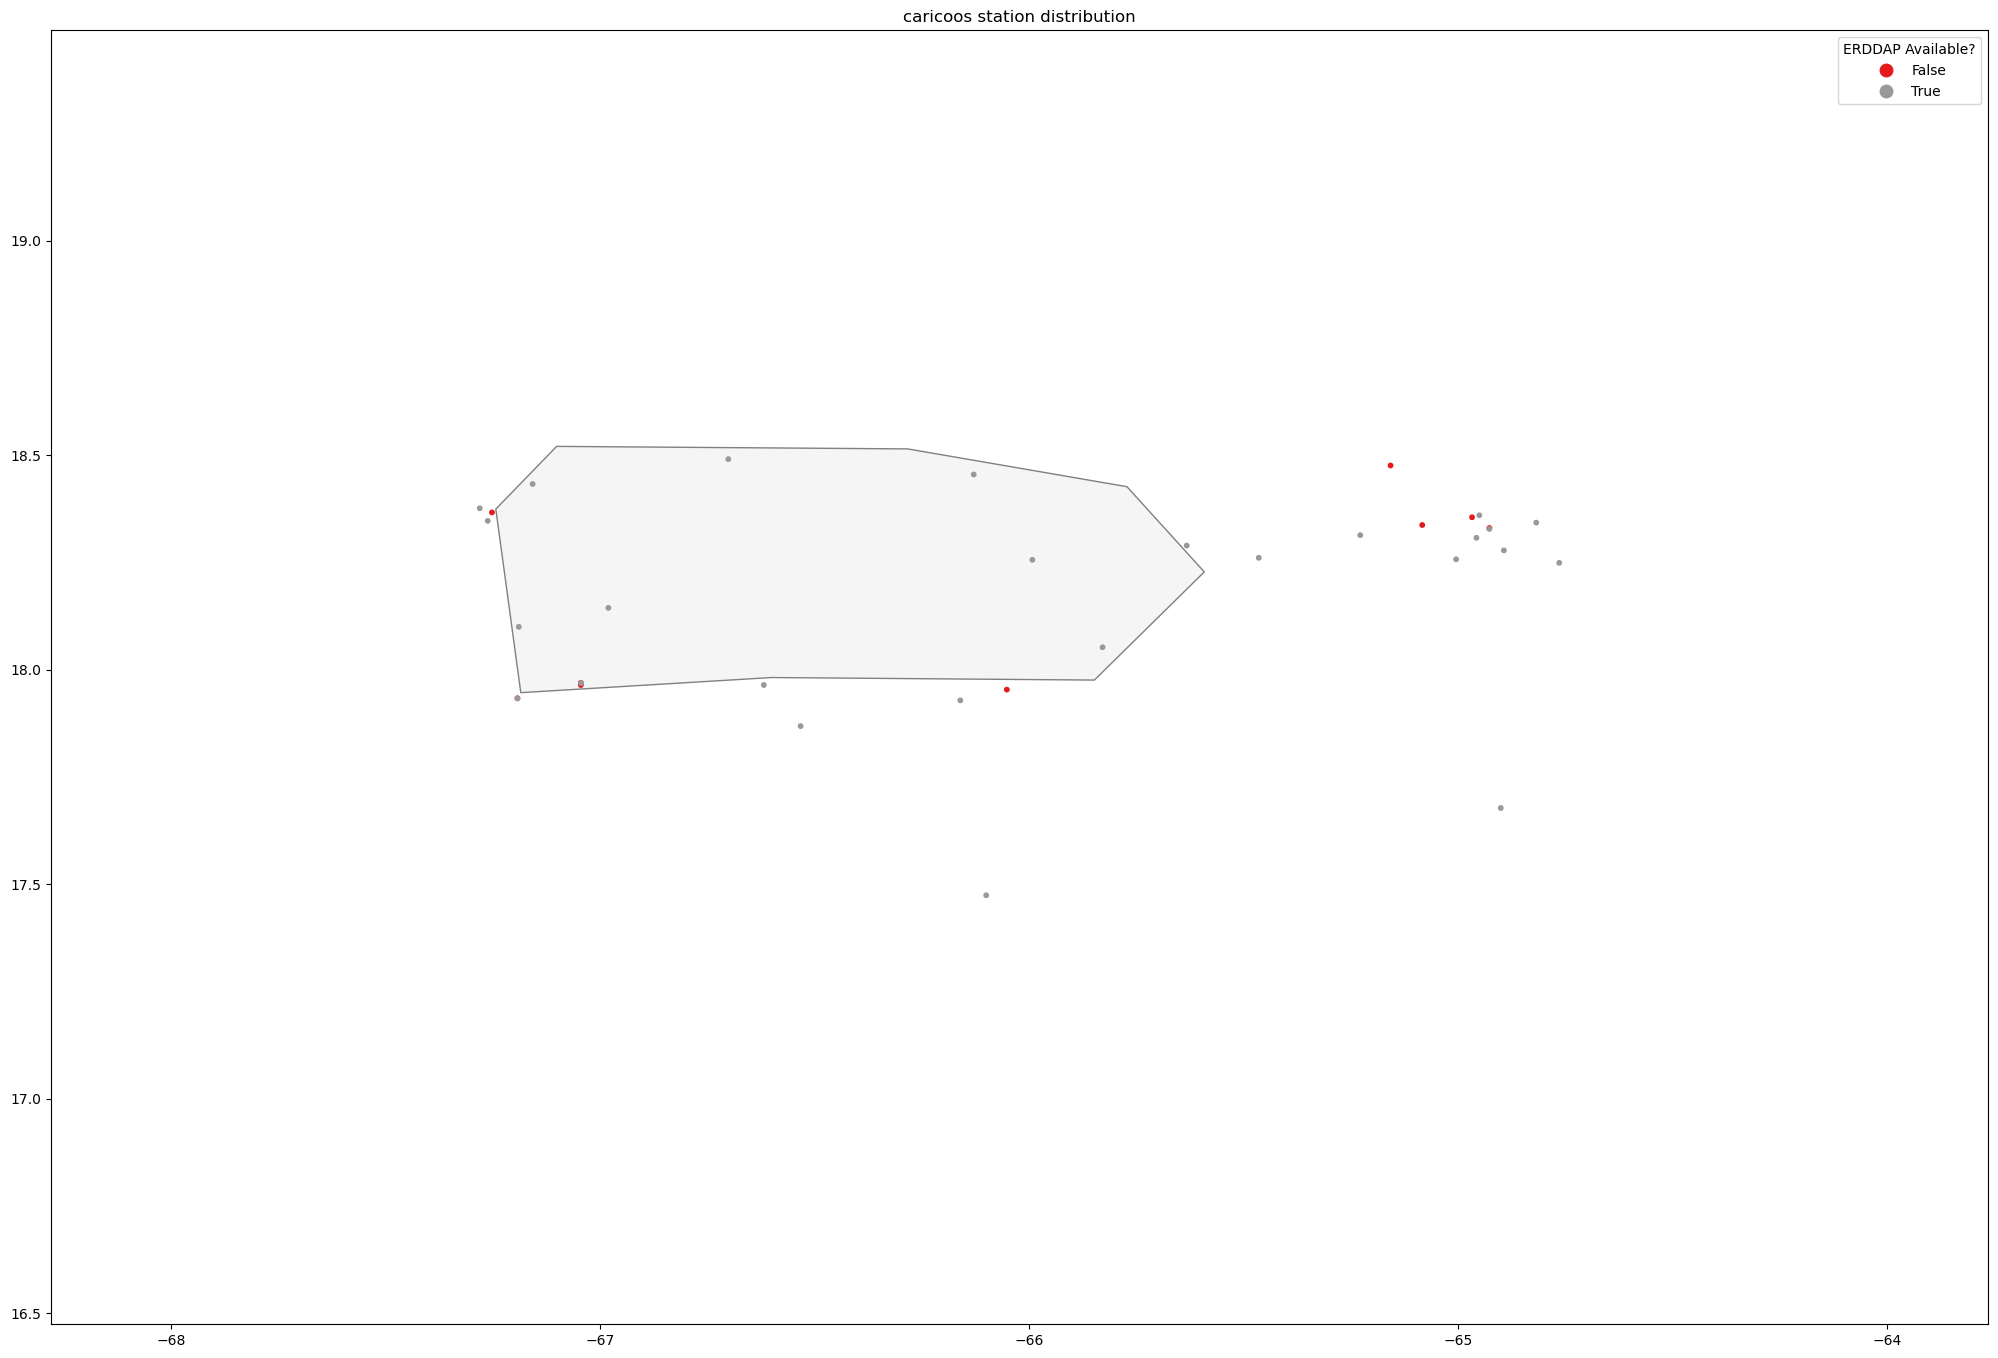

In [ ]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [ ]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [ ]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Time Period,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact\n(Name and Email),geometry,erddap_avail


In [ ]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [ ]:
gdf_final.loc[~gdf_final['erddap_avail']]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Time Period,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact\n(Name and Email),geometry,erddap_avail
4,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,nan,Offline,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,Patricia Chardón-Maldonado\npatricia.chardon@c...,POINT (-65.15680 18.47610),False
8,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,nan,Operational,...,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),POINT (-66.05120 17.95367),False
9,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,nan,Offline,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. Due to manufactur...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.25140 18.36670),False
10,MAGUEYES,IMGP4,"Isla Magueyes, PR",NaN,17.9694,-67.0442,Fixed,10/2015 - 9/2017,nan,No,...,N,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96940),False
11,MAGUEYES,F2397,"Isla Magueyes, PR",NaN,17.9644,-67.0442,Fixed,10/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (8 m), wind_speed_of_gust (8 m), wi...",Replaced IMGP4 station,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96440),False
13,FCR,E7866,Faro de Cabo Rojo - Cabo Rojo - Puerto Rico,NaN,17.9335,-67.192,Fixed,12/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (3 m), wind_speed_of_gust (3 m), wi...",Replaced by XCRL (Weatherflow Inc.),Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.19200 17.93350),False
16,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.92640 18.33030),False
27,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-65.08300 18.33737),False
28,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,nan,No,...,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...","This station was replaced with Crown Mountain,...",Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.96693 18.35537),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [ ]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "vi2" + RA "caricoos"
Query: https://data.ioos.us/dataset/?q="vi2"%20-glider&organization=caricoos
	found 4 dataset(s):
	 CARICOOS VI1 - St. John USVI Doppler Aggregated Buoy Observations
	 http://dm1.caricoos.org/thredds/dodsC/UMO/DSG/SOS/VI1/Doppler/HistoricRealtime/Agg.ncml
	 Coverage Meta:
		 2011-04-15T17:00:00Z  -  2025-02-28T05:00:00Z 

	Coverage Data:
		 2011-04-15T17:00:00.000013312  -  2025-03-04T14:00:00.000013312 

	VI2 is valid.
Station "mapco2" + RA "caricoos, oap"
Query: https://data.ioos.us/dataset/?q="mapco2"%20-glider&organization=caricoos,%20oap
	No datasets found!
Station "puntas" + RA "caricoos"
Query: https://data.ioos.us/dataset/?q="puntas"%20-glider&organization=caricoos
	No datasets found!
Station "magueyes" + RA "caricoos"
Query: https://data.ioos.us/dataset/?q="magueyes"%20-glider&organization=caricoos
	No datasets found!
Station "magueyes" + RA "caricoos"
Query: https://data.ioos.us/dataset/?q="magueyes"%20-glider&organization=caricoos
	No datasets f

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [ ]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Time Period,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,CARICOOS Contact\n(Name and Email),geometry,erddap_avail
8,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,nan,Operational,...,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,Julio Morell \n(julio.morell@upr.edu),POINT (-66.05120 17.95367),False
9,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,nan,Offline,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. Due to manufactur...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.25140 18.36670),False
10,MAGUEYES,IMGP4,"Isla Magueyes, PR",NaN,17.9694,-67.0442,Fixed,10/2015 - 9/2017,nan,No,...,N,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96940),False
11,MAGUEYES,F2397,"Isla Magueyes, PR",NaN,17.9644,-67.0442,Fixed,10/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (8 m), wind_speed_of_gust (8 m), wi...",Replaced IMGP4 station,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.04420 17.96440),False
13,FCR,E7866,Faro de Cabo Rojo - Cabo Rojo - Puerto Rico,NaN,17.9335,-67.192,Fixed,12/2018 - present,nan,No,...,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,Gladstone / CARICOOS,"wind_speed (3 m), wind_speed_of_gust (3 m), wi...",Replaced by XCRL (Weatherflow Inc.),Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-67.19200 17.93350),False
16,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.92640 18.33030),False
27,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,nan,No,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-65.08300 18.33737),False
28,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,nan,No,...,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...","This station was replaced with Crown Mountain,...",Patricia Chardón-Maldonado (patricia.chardon@u...,POINT (-64.96693 18.35537),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [ ]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': 'e10c0075-19cf-4395-8f0f-52c53dc0d8a5',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2024-08-03T09:20:34.598375',
 'metadata_modified': '2025-02-28T15:41:13.834546',
 'name': 'xwgo-crown-mountain-usvi-aggregated-meteorological-observations',
 'notes': 'Realtime-Historical aggregated dataset from the Mesonet meteorological station network funded by CARICOOS and operated by Weatherflow Inc.',
 'num_resources': 4,
 'num_tags': 11,
 'organization': {'id': '2c66095c-e48c-4dff-9f82-c6427926c81a',
  'name': 'caricoos',
  'title': 'CariCOOS',
  'type': 'organization',
  'description': 'CARICOOS is the Regional Association of the national Integrated Ocean Observing System (IOOS®) in the US Caribbean, primarily Puerto Rico and the US Virgin Islands. We provide data and products to inform decision-making 

In [ ]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [ ]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]